## Trabalho final

O seguinte trabalho tem por objetivo desenvolver uma rede neural capaz de prever a altura de um rio baseado nos valores dos últimos 15 dias anteriores
Para isso utilizou-se Redes Neurais Recorrentes (LSTM) dado sua alta eficácia com séries temporais

## Importação das bibliotecas

In [570]:
import pandas as pd
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Análise exploratória dos dados

In [571]:
def read_archive(path_arquivo):
    lines = [] 
    with open(path_arquivo) as arquivo:
        for line in arquivo:
            lines.append(line.split())
    df = pd.DataFrame(lines, columns= ['DIA', 'MES', 'ANO', 'MEDICAO'])
    return df

def dados(dado):
    ano = dado['ANO']
    mes = dado['MES']
    dia = dado['DIA']
    medidas = {"DATA":[], "MEDICAO":[]}
    for med in range(len(dado['ANO'])):
        if float(dado['MEDICAO'][med]) > 0:
            d = int(dia[med])
            m = int(mes[med])
            medidas['DATA'].append(date(int(ano[med]), m, d))
            medidas['MEDICAO'].append(float(dado['MEDICAO'][med]))
    return medidas

In [572]:
df = read_archive("15700000.txt")

In [573]:
df = pd.DataFrame(dados(df))

In [574]:
def calcula_media_mensal(df):
    medias_mensais = {'data':[], 'media': []}
    for x in range(len(df)):
        ano = df.DATA[x].year
        mes = df.DATA[x].month
        
        somatorio = 0
        qtd_medicoes = 0
        
        for m in range(x, len(df)):
        
            if df.DATA[m].month != mes:
                break
            else:
                somatorio+=df.MEDICAO[m]
                qtd_medicoes+=1
        if date(int(ano), mes, 15) not in medias_mensais['data']:
            
            medias_mensais['data'].append(date(int(ano), mes, 15))
            medias_mensais['media'].append(somatorio/qtd_medicoes)
            
    return medias_mensais

In [575]:
import matplotlib.pyplot as plt

def plot(quem, x,y, titulo, x_description, y_description, color, xticks= False, yticks= False, size= (14,3), name = ''):

    colors = {'Blue': ('#00243c', '#00507D', '#0392BE', '#07ADC7', '#45C7C9', '#45C7C9', '#D6FFFD'), 
              'Green': ('#FFFFFF','#A3DFC3', '#6AB982', '#5E885B','#4A692D','#618700', '#4A692D')}
    if quem.upper() == 'Joao':
        cor = 'Blue'
    else:
        cor = 'Green'
    ax = plt.axes()
    plt.gcf().set_size_inches(size)

    ax.plot(x,y, color = colors[cor][color['line']])
    
    
    ax.set_title(str(titulo), fontdict=None, loc='center', pad=None)    
    ax.set_xlabel(x_description)
    ax.set_ylabel(y_description)
    #ax.set_axis_off()
    
    if name == '':
        fgura = 'figura'
    else:
        fgura = name
    
    plt.savefig(f'{fgura}.png', dpi= 200, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    return None


Os dados foram coletados da estação hidrológica da cidade de Humaitá - AM

Os dados correspondem á valores de cota (altura do rio) na estação hidrológica

Vale ressaltar que os valores se referem a bacia hidrográfica do Rio Madeira

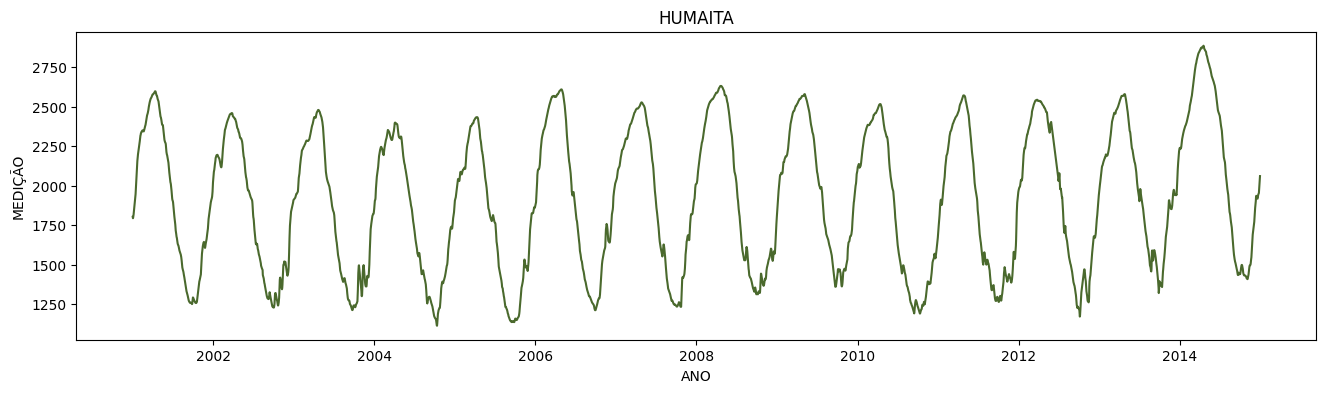

In [576]:
df.MEDICAO.max()
medias = pd.DataFrame(calcula_media_mensal(df))

plot('FERNANDO', df.DATA, df.MEDICAO, 'HUMAITA', 'ANO', 'MEDIÇÃO', {'background': 6, 'line': 4, 'y_ticks' : 3}, size= (16,4))

## Preparação dos dados

In [577]:
df

,DATA,MEDICAO
0,2001-01-01,1803.0
1,2001-01-02,1794.0
2,2001-01-03,1799.0
3,2001-01-04,1808.0
4,2001-01-05,1818.0
...,...,...
5108,2014-12-27,1982.0
5109,2014-12-28,1996.0
5110,2014-12-29,2017.0
5111,2014-12-30,2042.0


In [578]:
date_time = pd.to_datetime(df.pop('DATA'), format='%Y-%m-%d')

In [579]:
df

,MEDICAO
0,1803.0
1,1794.0
2,1799.0
3,1808.0
4,1818.0
...,...
5108,1982.0
5109,1996.0
5110,2017.0
5111,2042.0


In [580]:
df.values
df = df.astype('float32')

Normalização dos dados

In [581]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [582]:
df

array([[0.38895148],
       [0.38387817],
       [0.38669676],
       ...,
       [0.5095828 ],
       [0.52367526],
       [0.5343855 ]], dtype=float32)

Função para criar arrays de 16 dias (15 dias para atributos preditores e 1 dia para atributo alvo)

In [583]:
def datasetLSTM(dataset, quantidade):
    df = []
    for i in range(len(dataset)):
        lista=[]
        try:
            lista.append(dataset[i])
            for j in range (quantidade+1):
                lista.append(dataset[i+j+1])
            df.append(lista)
        except:
            print("erro")
    return df

In [584]:
df2 = datasetLSTM(df, 14)

erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro
erro


In [585]:
df2

[[array([0.38895148], dtype=float32),
  array([0.38387817], dtype=float32),
  array([0.38669676], dtype=float32),
  array([0.39176995], dtype=float32),
  array([0.397407], dtype=float32),
  array([0.40529877], dtype=float32),
  array([0.41488165], dtype=float32),
  array([0.42108232], dtype=float32),
  array([0.427283], dtype=float32),
  array([0.43517476], dtype=float32),
  array([0.4408117], dtype=float32),
  array([0.4492672], dtype=float32),
  array([0.45828635], dtype=float32),
  array([0.47012395], dtype=float32),
  array([0.4859075], dtype=float32),
  array([0.50338215], dtype=float32)],
 [array([0.38387817], dtype=float32),
  array([0.38669676], dtype=float32),
  array([0.39176995], dtype=float32),
  array([0.397407], dtype=float32),
  array([0.40529877], dtype=float32),
  array([0.41488165], dtype=float32),
  array([0.42108232], dtype=float32),
  array([0.427283], dtype=float32),
  array([0.43517476], dtype=float32),
  array([0.4408117], dtype=float32),
  array([0.4492672], dt

Datset de 16 dias

In [586]:
dfTest = pd.DataFrame(df2)
dfTest = dfTest.astype("float")
dfTest.columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']
dfTest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.388951,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382
1,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729
2,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386
3,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.551860
4,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.551860,0.565389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093,0.445321,0.458850,0.463923,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853
5094,0.458850,0.463923,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853,0.497745
5095,0.463923,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853,0.497745,0.509583
5096,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853,0.497745,0.509583,0.523675


Partição holdout 80,20
80% dados de treino
20% dados de teste

In [587]:
test_size = int(len(dfTest) * 0.2)
test = dfTest.iloc[-test_size::].copy()
train = dfTest.iloc[:-test_size:].copy()

In [588]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.388951,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382
1,0.383878,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729
2,0.386697,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386
3,0.391770,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.551860
4,0.397407,0.405299,0.414882,0.421082,0.427283,0.435175,0.440812,0.449267,0.458286,0.470124,0.485907,0.503382,0.519729,0.534386,0.551860,0.565389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074,0.740699,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378
4075,0.744645,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069
4076,0.748591,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323
4077,0.754791,0.764374,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323,0.801578


In [589]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4079,0.768884,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323,0.801578,0.803269,0.804397
4080,0.771139,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323,0.801578,0.803269,0.804397,0.804961
4081,0.773393,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323,0.801578,0.803269,0.804397,0.804961,0.804961
4082,0.776776,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323,0.801578,0.803269,0.804397,0.804961,0.804961,0.804397
4083,0.780158,0.783540,0.786922,0.789177,0.791432,0.793687,0.795378,0.797069,0.799323,0.801578,0.803269,0.804397,0.804961,0.804961,0.804397,0.804397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093,0.445321,0.458850,0.463923,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853
5094,0.458850,0.463923,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853,0.497745
5095,0.463923,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853,0.497745,0.509583
5096,0.463360,0.461105,0.458850,0.456595,0.454340,0.453777,0.457723,0.464487,0.467869,0.470124,0.471815,0.474070,0.489853,0.497745,0.509583,0.523675


In [590]:
X_train = train.drop("15",axis=1).copy()

In [591]:
y_train = train[["15"]].copy()
y_train

,15
0,0.503382
1,0.519729
2,0.534386
3,0.551860
4,0.565389
...,...
4074,0.795378
4075,0.797069
4076,0.799323
4077,0.801578


Os modelos serão executados usando a biblioteca tensorflow e o framework keras, portanto os valores usados nas execuções não podem ser classes da biblioteca Pandas

Logo, faz-se necessário a transformação para arrays Numpy

In [592]:
scaled_X_train = X_train.to_numpy()

In [593]:
scaled_X_train

array([[0.38895148, 0.38387817, 0.38669676, ..., 0.45828635, 0.47012395,
        0.4859075 ],
       [0.38387817, 0.38669676, 0.39176995, ..., 0.47012395, 0.4859075 ,
        0.50338215],
       [0.38669676, 0.39176995, 0.397407  , ..., 0.4859075 , 0.50338215,
        0.51972944],
       ...,
       [0.74859077, 0.75479144, 0.7643742 , ..., 0.79368657, 0.79537767,
        0.79706877],
       [0.75479144, 0.7643742 , 0.76888388, ..., 0.79537767, 0.79706877,
        0.7993235 ],
       [0.7643742 , 0.76888388, 0.77113861, ..., 0.79706877, 0.7993235 ,
        0.80157834]])

In [594]:
scaled_y_train = y_train.to_numpy()
scaled_y_train

array([[0.50338215],
       [0.51972944],
       [0.5343855 ],
       ...,
       [0.7993235 ],
       [0.80157834],
       [0.80326945]])

In [595]:
scaled_y_train = scaled_y_train.reshape(-1)
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

In [596]:
scaled_y_train

array([0.        , 0.50338215, 0.51972944, ..., 0.79706877, 0.7993235 ,
       0.80157834])

Criação dos valores de entrada

In [597]:
n_input = 15
n_features= X_train.shape[1]
b_size = 32
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

In [598]:
print(generator[0][0].shape)

(32, 15, 15)


## Execução

Geração das arquiteturas

Para este trabalho optou-se por uma rede LSTM com 150 unidades (hidden states) e 1 camada oculta

In [599]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 150)               99600     
                                                                 
 dense_7 (Dense)             (None, 1)                 151       
                                                                 
Total params: 99,751
Trainable params: 99,751
Non-trainable params: 0
_________________________________________________________________


Execução do treino

In [600]:
model.fit_generator(generator,epochs=20)

Epoch 1/20


C:\Users\hacke\AppData\Local\Temp\ipykernel_20800\3989200883.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20)


127/127 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 2/20
127/127 [==============================] - 1s 8ms/step - loss: 0.0016
Epoch 3/20
127/127 [==============================] - 1s 8ms/step - loss: 9.2414e-04
Epoch 4/20
127/127 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 5/20
127/127 [==============================] - 1s 9ms/step - loss: 8.7270e-04
Epoch 6/20
127/127 [==============================] - 1s 10ms/step - loss: 4.4785e-04
Epoch 7/20
127/127 [==============================] - 1s 10ms/step - loss: 4.8904e-04
Epoch 8/20
127/127 [==============================] - 1s 9ms/step - loss: 6.4314e-04
Epoch 9/20
127/127 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 10/20
127/127 [==============================] - 1s 9ms/step - loss: 0.0010
Epoch 11/20
127/127 [==============================] - 1s 9ms/step - loss: 4.4009e-04
Epoch 12/20
127/127 [==============================] - 1s 8ms/step - loss: 3.5863e-04
Epoch 

Gráfico de loss durante o treino

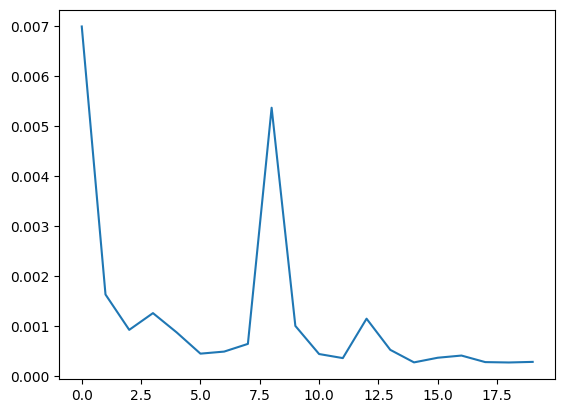

In [601]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

Teste

In [602]:
y_test = test[["15"]]
scaled_y_test = y_test.to_numpy()
scaled_y_test

array([[0.80439681],
       [0.80496055],
       [0.80496055],
       ...,
       [0.50958282],
       [0.52367526],
       [0.5343855 ]])

In [603]:
X_test = test.drop("15",axis=1).copy()
scaled_X_test  = X_test.to_numpy()
test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)

Predição do modelo

In [604]:
y_pred_scaled = model.predict(test_generator)

32/32 [==============================] - 0s 3ms/step


In [605]:
y_pred_scaled

array([[0.787896  ],
       [0.78738385],
       [0.78703415],
       ...,
       [0.47395346],
       [0.4796287 ],
       [0.48712724]], dtype=float32)

In [606]:
results = pd.DataFrame({'Dados Reais':test["15"].values[n_input:],'Dados Previstos':y_pred_scaled.ravel()})

Gráfico de valores 

reais x previsão

<Axes: title={'center': 'Gráfico de comparação dados reais x previstos'}>

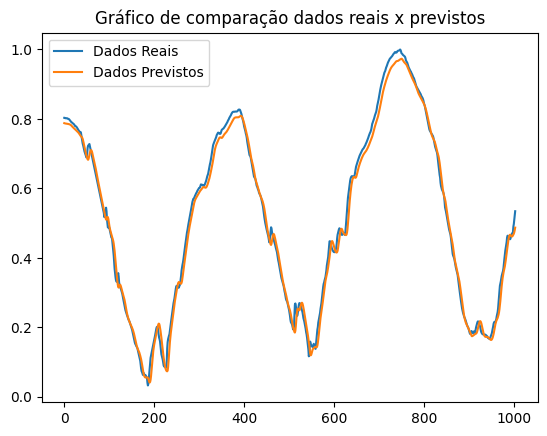

In [607]:
results.plot(title="Gráfico de comparação dados reais x previstos")

## Métricas de desempenho

In [608]:
import tensorflow as tf

Mean Squared Error

In [609]:
mse = tf.keras.losses.MeanSquaredError()

In [616]:
print("Mean Squared Error: " + str(mse(test["15"].values[n_input:], y_pred_scaled).numpy()))

Mean Squared Error: 0.13650659


Root Mean Squared Error

In [611]:
rmse = tf.keras.metrics.RootMeanSquaredError()

In [617]:
print("Root Mean Squared Error: " + str(rmse(test["15"].values[n_input:], y_pred_scaled).numpy()))

Root Mean Squared Error: 0.022998778


Mean Absolute Error

In [613]:
mae = tf.keras.losses.MeanAbsoluteError()

In [619]:
print("Mean Absolute Error: " + str(mae(test["15"].values[n_input:], y_pred_scaled).numpy()))

Mean Absolute Error: 0.30096096
